In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openpyxl import load_workbook

from scipy import stats as stats
from copy import copy as copy


In [2]:
# read in paths from config file

configDict = {
    'rootDir': '',
    'initialDataPath' : '',
    'QCDataPath' : '',
    # 'labWorksheet01Path':'',
    'projectName':''
}

# with open(os.path.join(workingDir, 'config.txt'),'r') as f:
with open('config.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith('#'):
            line = line.strip()
            fields = line.split(':')

            if fields[0].strip()=='initialDataPath':
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
            else:
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
## ToDo: Add checks to ensure that minimal fields have been populated. Raise errors or warnings


In [3]:
configDict

{'rootDir': '/Users/upton6/Documents/Nanostring/Projects/NS_msWTA/DSP_Output/Annotated/',
 'initialDataPath': 'Initial Dataset Updated.xlsx',
 'QCDataPath': 'QC_Updated.xlsx',
 'projectName': 'Subramaniam_msWTA',
 'DCCPath': ''}

# Define functions

In [4]:
class master_data:
    def __init__(self, dataPath):
        ### import data from excel workbook
        
        self.wb = load_workbook(dataPath)
        self.segWs = self.wb['SegmentProperties']
        self.cntWs = self.wb['BioProbeCountMatrix']
        
        self.segValues = [[y.value for y in x] for x in self.segWs[self.segWs.calculate_dimension()]]
        self.cntValues = [[y.value for y in x] for x in self.cntWs[self.cntWs.calculate_dimension()]]

        self.dropData = False
        
        
    def get_data(self):
        ### Convert nested list to a pandas dataFrame and extract expression data with labels
        cntData = self.cntValues
        cntCols = self.cntValues[0]
        df = pd.DataFrame(self.cntValues)
        cntIndex = [x[0] for x in self.cntValues[1:]]
        cntDF = pd.DataFrame(self.cntValues[1:], index=cntIndex, columns=cntCols)
        self.counts = cntDF.iloc[:,12:]
        self.counts = self.counts.astype(np.float64)      # Convert datatype to float64
        self.priobeInfo = cntDF.iloc[:,:12]
        segCols = self.segValues[0]
        segIndex = [x[4].replace(' | ',('_')) for x in self.segValues[1:]]
        self.segData = pd.DataFrame(self.segValues[1:], index=segIndex, columns=segCols)

        self.dataOrig = self.counts.copy()
        self.dataLog1 = np.log2(self.counts+1)            # Log transform data for QC and analysis steps

        self.probeClass = False                           # Keep a copy of the original data before transformation or normalisation
        # self.probeClass = df.iloc[self.targIdx:,2]      ### Index needs updating here also
        # self.probeClass.rename(index=rowLabels, inplace=True)
        # self.probeClass.rename(index='ProbeClass', inplace=True)

        # ToDo: Need to update probeclass handling and labeling
        
        self.probeClassDict = {
            'Positive': 'A',
            'Negative': 'B',
            'Control': 'C',
            'Endogenous': 'E'}

        return(self.counts, self.priobeInfo, self.segData)

    def get_descriptors(self):
        pass

    def add_class_mean(self, df):
        pass

    def drop_AOIs(self, includes, writeOrig=False):
        pass
        
    def set_threshold(self, threshold):
        self.threshold = threshold
        # ToDo: Check that all values in master data are also included in threshold dataFrame
        # ToDo: Convert threshold data to 0/1 data if needed

    def drop_probes(self, labels):
        pass
        


In [5]:
def plot_SA_Hist(surfArea):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(surfArea, bins=50)
    ax.set_xlabel('AOI Surface Area µm', fontdict=labelFont)
    ax.set_ylabel('Count', fontdict=labelFont)
    ax.set_title('AOI Surface Area distribution', fontdict=titleFont)
    print('Min SA')
    print(min(surfArea))
    print('Max SA')
    print(max(surfArea))
    return(fig)


In [6]:
# Plot log2 transformed raw data before any normalisation

def draw_probe_plot(dataRaw, dataSortedRaw, namedColourList, title, exp=False, violin=False):
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    if exp:
        ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
    else:
        ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)

    
    if violin:
        if exp:
            ax.violinplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1)

    #         ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
        else:
            ax.violinplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T)

    #         ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)
        
        
    else:


        for i,j in enumerate(dataSortedRaw.index):
            y = dataRaw.drop(labels=['mean','probeClass'], axis=1).loc[j]
            colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'TME' else namedColourList[1] for v in y.index]
        #     colours = [colourList[2] if v.split('_')[-1] == 'Tumour' else colourList[5] if v.split('_')[-1] == 'Immune' else colourList[1] for v in y.index]
            y = y
            if exp:
                y = np.exp2(y.values)-1
            else:
                y = y.values

            x = np.random.normal(i+1, 0.1, len(y))

            for i in range(len(x)): 
                ax.plot(x[i], y[i], c=colours[i], marker='.', alpha=0.25)

    ax.set_xticks(np.arange(1,len(dataSortedRaw.index)+1,1))
    ax.set_xlabel=list(dataSortedRaw.index)
    
    print(len(np.arange(0,len(dataSortedRaw.index),1)))
    print(len(list(dataSortedRaw.index)))
    
    ax.tick_params(axis='x', labelrotation = 90)
    

    if exp:
        ax.semilogy()
        ax.set_title(title + ' (untransformed)', size=36)
        ax.set_ylabel('Probe value', size=24)
    else:
        ax.set_title(title + ' (Log2 transformed)', size=36)
        ax.set_ylabel('Log2 probe value', size=24)
#     plt.show()
    
    return(fig)


In [7]:
def probe_GeoMean_Plots(plotData, title=''):
    rows=1
    cols=2
    colours = [namedColourList[2] if x.split('_')[-1] == 'Tumour' else namedColourList[5] if x.split('_')[-1] == 'TME' else namedColourList[1] for x in HKGeoMean.index]

    fig,ax = plt.subplots(rows,cols, sharey=True, gridspec_kw={'width_ratios': [4,1]}, figsize=(15,5))
    ax[0].bar(np.linspace(1,len(plotData),len(plotData)), plotData, color=colours)
    ax[1].hist(plotData, bins=int(len(plotData)/10),orientation='horizontal', color='k')
    ax[0].set_xlim(0,len(plotData))
    
    ax[0].text(2,max(plotData)*.95,'Tumour', size=20, c=namedColourList[2])
    ax[0].text(2,max(plotData)*.825,'TME', size=20, c=namedColourList[5])
    ax[0].text(2,max(plotData)*.7,'Other', size=20, c=namedColourList[1])

    fig.suptitle(title, size=36)
    ax[0].set_ylabel('Probe Value', size=18)
    ax[0].set_xlabel('Probes', size=18)
    ax[1].set_xlabel('Count', size=18)

    fig.tight_layout()

In [8]:
class threshold_probes:
    def __init__(self, data, bins):
        
        self.data = data.drop(labels=['mean','probeClass'], axis=1)
        self.bins = bins
        self.thisHist = plt.hist(self.data.values.flatten(), bins = self.bins)

    def zoom_plot(self, start, end):
        plt.hist(self.data.values.flatten(), bins = self.bins)
        plt.xlim(0,3)        
        
    def check_threshold(self, start, end):
        print(self.thisHist[0][start:end])
        print(self.thisHist[1][start:end])

    def set_threshold_idx(self, idx):
        print(self.thisHist[0][idx])
        print(self.thisHist[1][idx])
        
        self.threshold_idx = idx
        self.threshold = self.thisHist[1][idx]

    def get_filter(self):
        self.ETfilter = self.data >= self.threshold
        return(self.ETfilter)


In [9]:
def binding_density_plot(sampleInfoExternal, selectedInfo, subSelection):
    # print('selectedInfo')
    # print(selectedInfo)
    
    if not (subSelection == None):
        selectedInfo = selectedInfo.loc[subSelection]
    if (type(selectedInfo) == pd.core.series.Series):
        selectedInfo = pd.DataFrame(selectedInfo).T
        
    comboUniques = []
    comboColourDictRev = {}
    for c in selectedInfo.columns:
        thisCol = selectedInfo[c]
        combined = '_'.join(thisCol.values)
        comboUniques.append(combined)
        comboColourDictRev[c] = combined
    comboUniques = sorted(list(set(comboUniques)))
    print('\nNumber of unique combinations: {}'.format(len(comboUniques)))
    # print(comboColourDictRev)

    gradient = np.linspace(0, 1, len(comboUniques))
    gradDict = dict(zip(comboUniques,gradient))
    
    sampleInfoExternal.sort_values(by=['Plate', 'Col', 'Row'], axis=1, inplace=True)
    # Binding Density plot:
    plt.figure(figsize=(40,10))
    my_cmap = plt.get_cmap("nipy_spectral")
    
    colours = []
    for c in sampleInfoExternal.columns:
        colours.append(gradDict[comboColourDictRev[c]])
    
    print('selectedInfo.index')
    print(list(selectedInfo.index))

    fig, ax = plt.subplots(figsize=(20,5))

    
    bar = ax.bar(sampleInfoExternal.columns,
            sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32), 
            color=my_cmap(colours)
           )#, bottom=0)
    ax.set_title('_'.join(selectedInfo.index))
    ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')
    # ax.legend()
    plt.show()

# ToDo: Add legend

# Import data from Nanostring initial dataset file.

In [10]:
dataPath = os.path.join(configDict['rootDir'],configDict['initialDataPath'])
dataPath = os.path.join(configDict['rootDir'],configDict['QCDataPath'])

masterData = master_data(dataPath)


counts, probes, segs = masterData.get_data()


counts

# probes

# segs

,PFAC_Liver_CD63_CD45_Col1A1 | 001 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 002 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 003 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 004 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 005 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 006 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 007 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 008 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 009 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 010 | Full ROI,...,SFAC_Female_2_SMA_CD45_Col1A1 | 032 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 033 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 034 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 035 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 036 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 037 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 038 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 039 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 040 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 041 | Full ROI
16995,60.0,74.0,61.0,51.0,66.0,59.0,53.0,90.0,83.0,54.0,...,89.0,76.0,89.0,69.0,65.0,83.0,55.0,85.0,66.0,69.0
21460,120.0,170.0,157.0,123.0,196.0,161.0,227.0,175.0,188.0,204.0,...,268.0,254.0,296.0,152.0,227.0,187.0,129.0,305.0,234.0,228.0
23249,85.0,106.0,71.0,82.0,98.0,106.0,76.0,107.0,138.0,102.0,...,176.0,165.0,167.0,91.0,123.0,110.0,76.0,171.0,119.0,97.0
23932,98.0,77.0,65.0,66.0,74.0,82.0,70.0,90.0,108.0,97.0,...,109.0,100.0,109.0,75.0,104.0,97.0,76.0,132.0,82.0,66.0
28331,70.0,80.0,71.0,65.0,87.0,74.0,72.0,106.0,135.0,89.0,...,108.0,116.0,129.0,70.0,103.0,113.0,82.0,126.0,116.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20178,61.0,58.0,44.0,42.0,55.0,55.0,47.0,62.0,90.0,54.0,...,65.0,70.0,70.0,53.0,73.0,66.0,54.0,65.0,67.0,57.0
16328,64.0,68.0,80.0,65.0,61.0,73.0,60.0,75.0,100.0,92.0,...,92.0,122.0,91.0,63.0,77.0,100.0,74.0,114.0,91.0,86.0
31320,91.0,72.0,55.0,63.0,92.0,103.0,75.0,98.0,114.0,88.0,...,106.0,124.0,138.0,70.0,78.0,88.0,77.0,124.0,93.0,89.0
20649,27.0,24.0,30.0,17.0,22.0,27.0,19.0,31.0,55.0,29.0,...,38.0,46.0,51.0,26.0,35.0,44.0,16.0,43.0,28.0,29.0


ToDo: Need to check that column names are unique in SegmentProperties!! KO has 2 entries in current version, need to trace down where this has been introduced.

In [11]:
dropCols = ['SlideName', 'ScanLabel', 'ROILabel', 'SegmentLabel',
            'SegmentDisplayName', 'Origin Instrument ID', 'AOISurfaceArea', 
            'AOINucleiCount', 'ROICoordinateX', 'ROICoordinateY', 
            'RawReads', 'AlignedReads', 'DeduplicatedReads', 'TrimmedReads', 
            'StitchedReads', 'SequencingSaturation', 'SequencingSetID', 
            'UMIQ30', 'RTSQ30', 'GeoMxNgsPipelineVersion', 'LOT_Mouse_NGS_Whole_Transcriptome_Atlas_RNA_1_0',
            'ROIID', 'SegmentID', 'ScanWidth', 'ScanHeight', 'ScanOffsetX', 'ScanOffsetY']

keepCols = [x for x in segs.columns if not x in dropCols]

for c in keepCols:
    print(c)
    print(len(set(segs[c])))
    print(set(segs[c]))
    print()

KO
2
{'True', 'False'}

HFHCD
2
{'True', 'False'}

Control
2
{'True', 'False'}

WT
2
{'True', 'False'}

TAA
2
{'True', 'False'}

QCFlags
4
{None, 'Low Sequencing Saturation', 'Low Percent Aligned Reads,Low Percent Stitched Reads', 'Low Percent Aligned Reads'}

CD63
4
{'CD63H', 'CD63L', 'CD63N', 'nil'}

Inclusion
4
{'INCL', 'INCH', 'INCN', 'nil'}

Genotype
1
{'Genotype'}

Lipid_Vacoule
4
{'LVN', 'LVL', 'LVS', 'nil'}

Sex
2
{'Female', 'Male'}

a_Sma
4
{'a_SmaN', 'a_SmaH', 'a_SmaL', 'nil'}

Mouse_ID
75
{'155', '', '14 3h', '12 2f', '130', '129', '14 1h', '149', '13 3c', '150', '14 2e', '137', '15 4b', '10 6d', '15 4c', '144', '140', '10 7a', '13 3b', '139', '10 7f', '154', '10 7e', '10 6e', '12 4 f', '12 10b', '10 6b', '147', '12 9j', '151', '138', '17 2d', '148', '159', '10 6f', '134', '133', '13 1e', '14 5b', '127', '161', '10 7b', '11 5d', '152', '12 4f', '14 1g', '14 4c', '158', '10 6h', '163', '141', '132', '131', '128', '136', '12 3i', '156', '10 6a', '13 3a', '12 5a', '12 2b', '143

ToDo: Save drop cols to config file.

   - Work out workflow to allow importing previous drop cols, and working with remaining drop cols to get final list (saving final dropped cols back to config file)





In [12]:
sampleInfoExternal = masterData.segData.copy()

In [13]:
sampleInfoExternal.columns

Index(['SlideName', 'ScanLabel', 'ROILabel', 'SegmentLabel',
       'SegmentDisplayName', 'Origin Instrument ID', 'KO', 'HFHCD', 'Control',
       'WT', 'TAA', 'QCFlags', 'AOISurfaceArea', 'AOINucleiCount',
       'ROICoordinateX', 'ROICoordinateY', 'RawReads', 'AlignedReads',
       'DeduplicatedReads', 'TrimmedReads', 'StitchedReads',
       'SequencingSaturation', 'SequencingSetID', 'UMIQ30', 'RTSQ30',
       'GeoMxNgsPipelineVersion', 'CD63', 'Inclusion', 'Genotype',
       'Lipid_Vacoule', 'Sex', 'a_Sma', 'Mouse_ID', 'Strain', 'Diet', 'ColA1',
       'Morphology', 'LOT_Mouse_NGS_Whole_Transcriptome_Atlas_RNA_1_0', 'CD45',
       'Location', 'Genotype', 'ROIID', 'SegmentID', 'ScanWidth', 'ScanHeight',
       'ScanOffsetX', 'ScanOffsetY'],
      dtype='object')

In [14]:
sampleInfoExternal['TrimmedReads']

PFAC_Liver_CD63_CD45_Col1A1_001_Full ROI       8166994
PFAC_Liver_CD63_CD45_Col1A1_002_Full ROI       9758881
PFAC_Liver_CD63_CD45_Col1A1_003_Full ROI       7537700
PFAC_Liver_CD63_CD45_Col1A1_004_Full ROI       7934115
PFAC_Liver_CD63_CD45_Col1A1_005_Full ROI       7558340
                                                ...   
SFAC_Female_2_SMA_CD45_Col1A1_037_Full ROI     9716622
SFAC_Female_2_SMA_CD45_Col1A1_038_Full ROI     7502563
SFAC_Female_2_SMA_CD45_Col1A1_039_Full ROI    14295781
SFAC_Female_2_SMA_CD45_Col1A1_040_Full ROI    10681395
SFAC_Female_2_SMA_CD45_Col1A1_041_Full ROI    10320545
Name: TrimmedReads, Length: 188, dtype: int64

In [15]:
print(masterData.probeClass)
print(masterData.probeClassDict)
# dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

nuclei = sampleInfoExternal['AOINucleiCount']
# print(nuclei)
surfArea = sampleInfoExternal['AOISurfaceArea']
# print(surfArea)

# dataLog1External, sampleInfoExternal = masterData.add_class_mean(masterData.dataLog1)

False
{'Positive': 'A', 'Negative': 'B', 'Control': 'C', 'Endogenous': 'E'}


In [16]:
# os.getcwd()

In [17]:
# configDict

In [18]:
# dataPath = os.path.join(configDict['rootDir'],configDict['initialDataPath'])

# masterData = master_data(dataPath)
# dataLog1External, sampleInfoExternal = masterData.get_data()

# # For the Thomas TMA study there are a number of additional AOIs to be used for data normalisation studies.
# # These should be removed before further data analysis and QC.

# print(masterData.probeClass)
# print(masterData.probeClassDict)
# # dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

# nuclei = sampleInfoExternal.loc['AOI nuclei count']
# surfArea = sampleInfoExternal.loc['AOI surface area']

# dataLog1External, sampleInfoExternal = masterData.add_class_mean(masterData.dataLog1)

In [19]:
# ### import data from excel workbook

# # wb = load_workbook('../../../Documents/Nanostring/projects/Dando/DSP_Analysis_Suite/Initial Dataset.xlsx')
# wb = load_workbook('../../../Documents/Nanostring/projects/McGovern/msWTA/Initial Dataset.xlsx')

# print(wb.sheetnames)


In [20]:
# ws = wb['SegmentProperties']

# segments = [[y.value for y in x] for x in ws[ws.calculate_dimension()]]
# segments

In [21]:
# ### Convert nested list to a pandas dataFrame and extract expression data with labels
# segs = pd.DataFrame(segments)
# segs.rename(columns=segs.loc[0], inplace=True)
# segs.drop(index=0, inplace=True)
# segs.reset_index(inplace=True, drop=True)
# segs

In [22]:
# segs.loc[segs['SlideName'] == 'Ms_OB_TMEM_8um_2022_08_18'].shape

In [23]:
slides = set(segs['SlideName'])

colLookup = dict(zip(slides,range(len(slides))))

In [24]:
colLookup

{'PFAC_Liver_CD63_CD45_Col1A1': 0,
 'SKC_Liver_Male_SMA_CD45_Col1A1': 1,
 'SKC_Male_Liver_2_SMA_CD45_Col1A1': 2,
 'SFAC_Female_2_SMA_CD45_Col1A1': 3,
 'SKC_Liver_Female_2_SMA_CD45_Col1A1': 4}

In [25]:
colMap = [colLookup[x]/len(slides) for x in segs['SlideName']]

# colMap = [colLookup[x] for x in segs['SlideName']]


In [26]:
colMap 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.4,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6

In [27]:
sum(segs['RawReads'])

2086393067

In [28]:
# plot aoi size vs read number

ToDo: Convert the following to subplots in a single figure

 - Add titles
 - Add legends

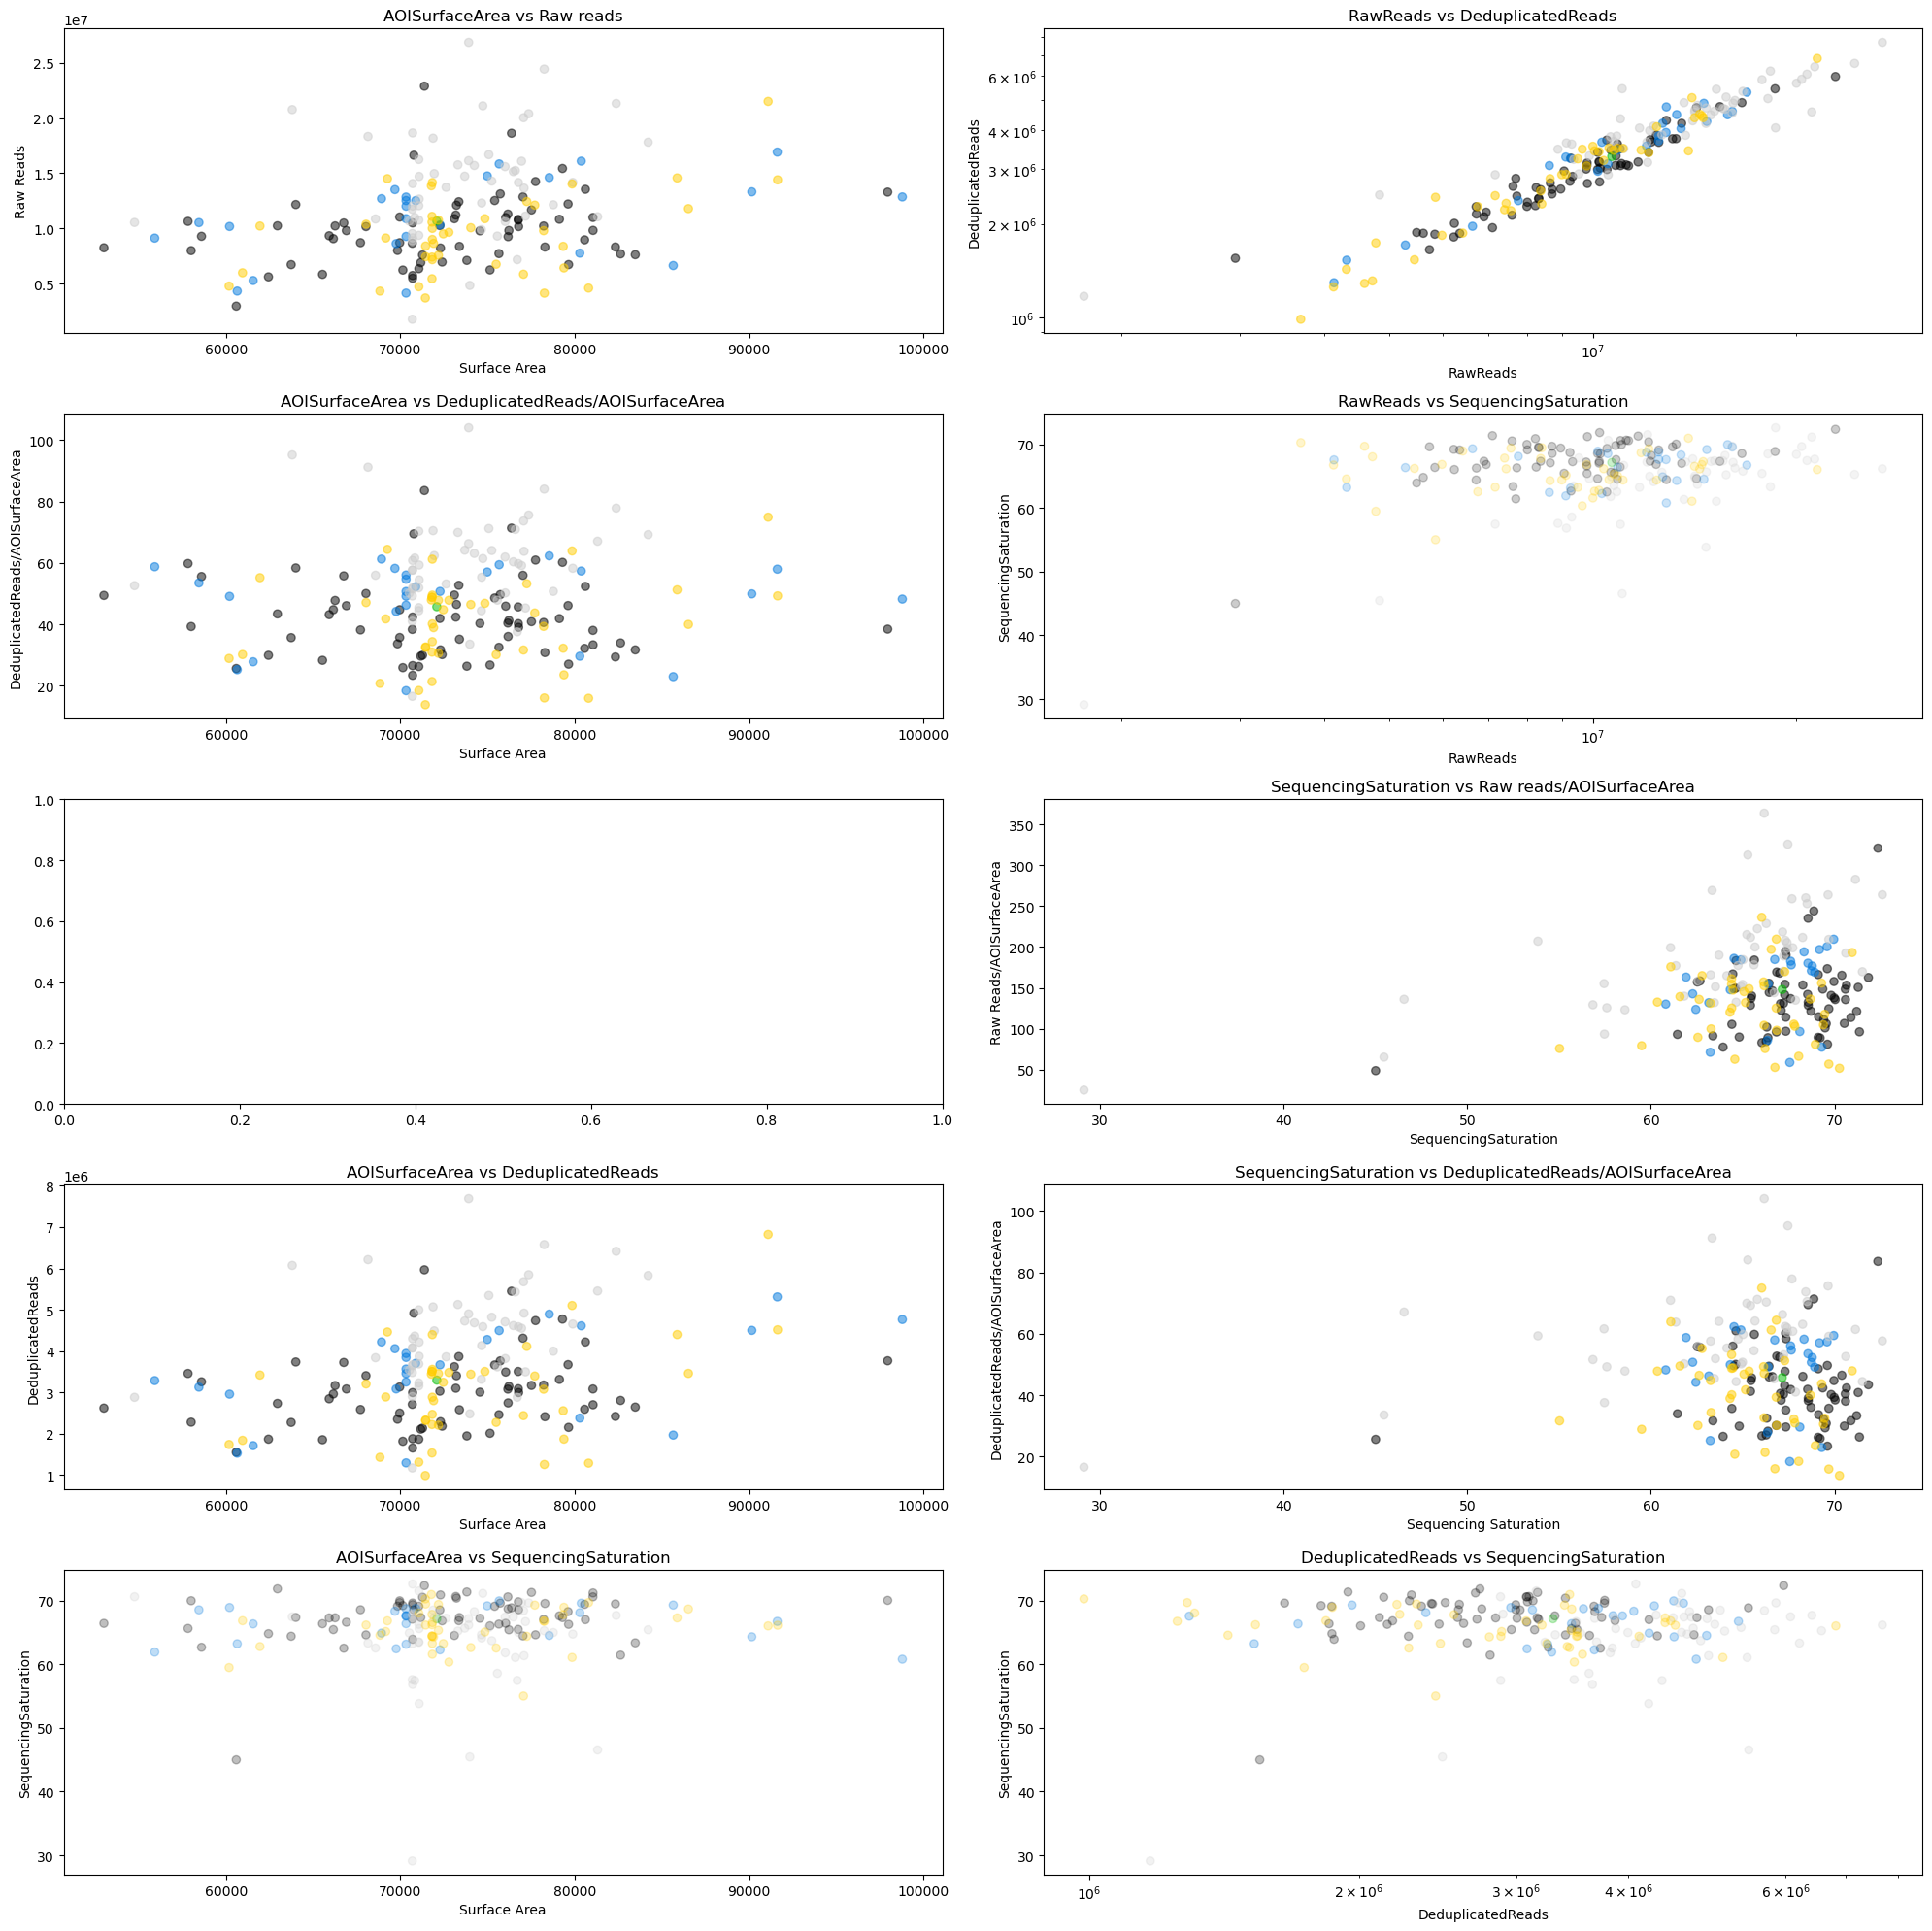

In [29]:
fig, ax = plt.subplots(5,2, figsize=[20,20])


ax[0][0].scatter(segs['AOISurfaceArea'],segs['RawReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[0][0].set_title('AOISurfaceArea vs Raw reads')
ax[0][0].set_xlabel('Surface Area')
ax[0][0].set_ylabel('Raw Reads')

ax[1][0].scatter(segs['AOISurfaceArea'],(segs['DeduplicatedReads']/segs['AOISurfaceArea']),alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[1][0].set_title('AOISurfaceArea vs DeduplicatedReads/AOISurfaceArea')
ax[1][0].set_xlabel('Surface Area')
ax[1][0].set_ylabel('DeduplicatedReads/AOISurfaceArea')

ax[3][0].scatter(segs['AOISurfaceArea'],segs['DeduplicatedReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[3][0].set_title('AOISurfaceArea vs DeduplicatedReads')
ax[3][0].set_xlabel('Surface Area')
ax[3][0].set_ylabel('DeduplicatedReads')

ax[4][0].scatter(segs['AOISurfaceArea'],segs['SequencingSaturation'],alpha=0.25, c=colMap, cmap='nipy_spectral')
ax[4][0].set_title('AOISurfaceArea vs SequencingSaturation')
ax[4][0].set_xlabel('Surface Area')
ax[4][0].set_ylabel('SequencingSaturation')



ax[0][1].scatter(segs['RawReads'],segs['DeduplicatedReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[0][1].semilogx()
ax[0][1].semilogy()
ax[0][1].set_title('RawReads vs DeduplicatedReads')
ax[0][1].set_xlabel('RawReads')
ax[0][1].set_ylabel('DeduplicatedReads')

ax[3][1].scatter(segs['SequencingSaturation'],segs['DeduplicatedReads']/segs['AOISurfaceArea'],alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[3][1].set_title('SequencingSaturation vs DeduplicatedReads/AOISurfaceArea')
ax[3][1].set_xlabel('Sequencing Saturation')
ax[3][1].set_ylabel('DeduplicatedReads/AOISurfaceArea')

ax[2][1].scatter(segs['SequencingSaturation'],segs['RawReads']/segs['AOISurfaceArea'],alpha=0.5, c=colMap, cmap='nipy_spectral')
ax[2][1].set_title('SequencingSaturation vs Raw reads/AOISurfaceArea')
ax[2][1].set_xlabel('SequencingSaturation')
ax[2][1].set_ylabel('Raw Reads/AOISurfaceArea')

ax[1][1].scatter(segs['RawReads'],segs['SequencingSaturation'],alpha=0.2, c=colMap, cmap='nipy_spectral')
ax[1][1].semilogx()
ax[1][1].set_title('RawReads vs SequencingSaturation')
ax[1][1].set_xlabel('RawReads')
ax[1][1].set_ylabel('SequencingSaturation')

ax[4][1].scatter(segs['DeduplicatedReads'],segs['SequencingSaturation'],alpha=0.25, c=colMap, cmap='nipy_spectral')
ax[4][1].semilogx()
ax[4][1].set_title('DeduplicatedReads vs SequencingSaturation')
ax[4][1].set_xlabel('DeduplicatedReads')
ax[4][1].set_ylabel('SequencingSaturation')


plt.tight_layout()
plt.savefig("QC_Plots.svg")
plt.show()

## Set up as selectable x and y axes using 

In [30]:
# plt.scatter(segs['AOISurfaceArea'],segs['RawReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')

In [31]:
# plt.scatter(segs['SequencingSaturation'],segs['RawReads']/segs['AOISurfaceArea'],alpha=0.5, c=colMap, cmap='nipy_spectral')
# plt.semilogy()

In [32]:
# plt.scatter(segs['SequencingSaturation'],segs['DeduplicatedReads']/segs['AOISurfaceArea'],alpha=0.5, c=colMap, cmap='nipy_spectral')


In [33]:
# plt.scatter(segs['AOISurfaceArea'],segs['DeduplicatedReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')
# plt.semilogy()

In [34]:
# plt.scatter(segs['AOISurfaceArea'],(segs['DeduplicatedReads']/segs['AOISurfaceArea']),alpha=0.5, c=colMap, cmap='nipy_spectral')
# plt.semilogy()

In [35]:
# plt.scatter(segs['RawReads'],segs['DeduplicatedReads'],alpha=0.5, c=colMap, cmap='nipy_spectral')
# plt.semilogx()
# plt.semilogy()

In [36]:
# segs['SequencingSaturation'].mean()

In [37]:
# segs['SequencingSaturation'].min()

In [38]:
# segs['SequencingSaturation'].max()

In [39]:
# sum(segs['SequencingSaturation']<50.0)

In [40]:
# sum(segs['SequencingSaturation']>=50.0)

In [41]:
# plt.scatter(segs['AOISurfaceArea'],segs['SequencingSaturation'],alpha=0.25, c=colMap, cmap='nipy_spectral')

In [42]:
# plt.scatter(segs.loc[segs['SlideName'] == 'RB15P48811_SOETENS. 1.A']['AOISurfaceArea'],segs.loc[segs['SlideName'] == 'RB15P48811_SOETENS. 1.A']['SequencingSaturation'])

# # segs.loc[segs['SlideName'] == 'RB15P48811_SOETENS. 1.A']['AOISurfaceArea']

In [43]:
# plt.scatter(segs['DeduplicatedReads'],segs['SequencingSaturation'],alpha=0.25, c=colMap, cmap='nipy_spectral')
# plt.semilogx()


In [44]:
# plt.scatter(segs['RawReads'],segs['SequencingSaturation'],alpha=0.2, c=colMap, cmap='nipy_spectral')
# plt.semilogx()
# plt.xlim(0,1E8)
# plt.ylim(0,100)
# # 

In [45]:
# plt.scatter(segs.loc[segs['SlideName'] == 'RB15P48811_SOETENS. 1.A']['RawReads'],segs.loc[segs['SlideName'] == 'RB15P48811_SOETENS. 1.A']['SequencingSaturation'])
# plt.xlim(0,1E8)
# plt.ylim(0,100)


In [46]:
# plt.scatter(segs['RawReads'],segs['DeduplicatedReads'],alpha=0.25, c=colMap, cmap='nipy_spectral')
# plt.semilogx()
# plt.semilogy()


# Investigate NTC wells


ToDo: Load in DCC data and parse info

 - Tie in with config file

In [87]:
dataPath = "/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/Nanostring/Projects/NS_msWTA/DND"

In [88]:
files = os.listdir(dataPath)
files = [x for x in files if x.endswith('.dcc')]

In [89]:
files

['DSP-1001660011354-B-A12.dcc',
 'DSP-1001660011354-B-A06.dcc',
 'DSP-1001660011355-A-C07.dcc',
 'DSP-1001660011354-B-C10.dcc',
 'DSP-1001660011354-B-C04.dcc',
 'DSP-1001660011355-A-A05.dcc',
 'DSP-1001660011355-A-A11.dcc',
 'DSP-1001660011354-B-E02.dcc',
 'DSP-1001660011354-B-D11 - F06T6WFQGG.dcc',
 'DSP-1001660011354-B-F12 - F06T6WFQGG.dcc',
 'DSP-1001660011354-B-A10 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-G03.dcc',
 'DSP-1001660011355-A-B02 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-F04 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-D07 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-G03 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-E01.dcc',
 'DSP-1001660011355-A-C05 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-A06 - F06T6WFQGG.dcc',
 'DSP-1001660011354-B-H09 - F06T6WFQGG.dcc',
 'DSP-1001660011354-B-G01.dcc',
 'DSP-1001660011354-B-E09 - F06T6WFQGG.dcc',
 'DSP-1001660011355-A-G02.dcc',
 'DSP-1001660011354-B-E03.dcc',
 'DSP-1001660011355-A-A10.dcc',
 'DSP-1001660011355-A-A04.dcc',
 'DSP-1001660011354-B-C05

In [95]:
thisFile = os.path.join(dataPath, "DSP-1001660011355-A-A01.dcc")
thisFile = os.path.join(dataPath, "DSP-1001660011354-B-A01.dcc")
# thisFile = os.path.join(dataPath, "DSP-1001660011355-A-A01.dcc")


In [96]:
with open(thisFile, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        print(line)
    # print(lines)

<Header>
FileVersion,0.02
SoftwareVersion,"GeoMx_NGS_Pipeline_2.3.3.10"
Date,2023-5-30
</Header>

<Scan_Attributes>
ID,DSP-1001660011354-B-A01
Plate_ID,1001660011354
Well,A01
</Scan_Attributes>

<NGS_Processing_Attributes>
SeqSetId,A00632:364:H533GDRX3
Raw,44250
Trimmed,36394
Stitched,496
Aligned,96
umiQ30,0.9950
rtsQ30,0.9918
</NGS_Processing_Attributes>


<Code_Summary>
RTS0065152,1
RTS0066741,1
RTS0069104,1
RTS0073075,1
RTS0073206,1
RTS0079236,1
</Code_Summary>


In [48]:
# dccPath = '../../../Documents/Nanostring/projects/Dando/DCC-2023XXXX/'

In [49]:
# walkOut = os.walk(dccPath)

In [50]:
# files = list(walkOut)[0][2]

In [51]:
# files

In [52]:
# NTCs = []
# for f in files:
#     if f.endswith('A01.dcc'):
#         NTCs.append(os.path.join(dccPath,f))
# #         print(f)
    

In [53]:
# NTCs

In [54]:
# NTCs = []
# for ntc in files:
#     if ntc.endswith('A01.dcc'):
#         print(ntc)
# #         NTCs.append(os.path.join(dccPath,ntc))
#         with open (os.path.join(dccPath,ntc),'r') as f:
#             counts = []
#             lines = f.readlines()
#             for line in lines[25:-1]:
# #                 print(line)
#                 counts.append(line.strip().split(','))
#             ds = pd.Series([x[1] for x in counts], index = [x[0] for x in counts], name=ntc.split('-')[1])
#             print(ds.shape)
#             NTCs.append(ds)
# #         break
        
        
        
# #         print(f)
    

In [55]:
# ds

In [56]:
# NTCFrame = pd.concat(NTCs, axis=1)
# NTCFrame.fillna(0, inplace=True)

In [57]:
# NTCFrame

In [58]:
# NTCFrame = NTCFrame.astype('int32')

In [59]:
# NTCFrame.dtypes

In [60]:
# NTCFrame.sum()

In [61]:

# for ntc in NTCs:
#     with open (ntc,'r') as f:
#         counts = []
#         lines = f.readlines()
#         for line in lines[25:-1]:
#             print(line)
#             counts.append(line.strip())
            
#         ds = pd.Series(counts, name=)
#     break
        
        

# Investigate Probe Matrix Counts


In [62]:
# ws = wb['BioProbeCountMatrix']

# counts = [[y.value for y in x] for x in ws[ws.calculate_dimension()]]
# counts

In [63]:
# ### Convert nested list to a pandas dataFrame and extract expression data with labels
# counts = pd.DataFrame(counts)
# counts.rename(columns=counts.loc[0], inplace=True)
# counts.drop(index=0, inplace=True)
# counts.reset_index(inplace=True, drop=True)
# counts

In [77]:
counts.columns

Index(['PFAC_Liver_CD63_CD45_Col1A1 | 001 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 002 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 003 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 004 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 005 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 006 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 007 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 008 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 009 | Full ROI',
       'PFAC_Liver_CD63_CD45_Col1A1 | 010 | Full ROI',
       ...
       'SFAC_Female_2_SMA_CD45_Col1A1 | 032 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 033 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 034 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 035 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 036 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 037 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 038 | Full ROI',
       'SFAC_Female_2_SMA_CD45_Col1A1 | 

In [65]:
# list(counts.columns)[12:]

In [66]:
# AOIs = list(counts.columns)[12:]

In [67]:
# negOrdered = counts.loc[counts['CodeClass'] == 'Negative', AOIs].sum().sort_values().index

In [68]:
# set(counts['CodeClass'])

In [69]:
# plt.figure(figsize=(10,10))
# plt.plot(counts.loc[counts['CodeClass'] == 'Negative', AOIs][negOrdered].T)

In [70]:
# There are no control probes in WTA

# plt.figure(figsize=(10,10))
# plt.plot(counts.loc[counts['CodeClass'] == 'Control', AOIs][negOrdered].T)

In [71]:
# counts.index = counts['TargetName']

In [72]:
# counts.drop(counts.columns[:12], axis=1, inplace = True)

In [73]:
counts.values.flatten().min()

1.0

In [74]:
counts = counts.astype(np.float32)
counts = np.log2(counts)
counts

,PFAC_Liver_CD63_CD45_Col1A1 | 001 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 002 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 003 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 004 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 005 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 006 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 007 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 008 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 009 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 010 | Full ROI,...,SFAC_Female_2_SMA_CD45_Col1A1 | 032 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 033 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 034 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 035 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 036 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 037 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 038 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 039 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 040 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 041 | Full ROI
16995,5.906890,6.209454,5.930737,5.672425,6.044394,5.882643,5.727921,6.491853,6.375040,5.754888,...,6.475733,6.247928,6.475733,6.108524,6.022368,6.375040,5.781360,6.409391,6.044394,6.108524
21460,6.906890,7.409391,7.294621,6.942514,7.614710,7.330917,7.826549,7.451211,7.554589,7.672425,...,8.066090,7.988685,8.209454,7.247928,7.826549,7.546895,7.011227,8.252666,7.870365,7.832890
23249,6.409391,6.727921,6.149747,6.357552,6.614710,6.727921,6.247928,6.741467,7.108524,6.672425,...,7.459432,7.366322,7.383704,6.507795,6.942514,6.781360,6.247928,7.417852,6.894818,6.599913
23932,6.614710,6.266787,6.022368,6.044394,6.209454,6.357552,6.129283,6.491853,6.754888,6.599913,...,6.768184,6.643856,6.768184,6.228819,6.700440,6.599913,6.247928,7.044394,6.357552,6.044394
28331,6.129283,6.321928,6.149747,6.022368,6.442944,6.209454,6.169925,6.727921,7.076816,6.475733,...,6.754888,6.857981,7.011227,6.129283,6.686501,6.820179,6.357552,6.977280,6.857981,6.066089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20178,5.930737,5.857981,5.459432,5.392317,5.781360,5.781360,5.554589,5.954196,6.491853,5.754888,...,6.022368,6.129283,6.129283,5.727921,6.189825,6.044394,5.754888,6.022368,6.066089,5.832890
16328,6.000000,6.087463,6.321928,6.022368,5.930737,6.189825,5.906890,6.228819,6.643856,6.523562,...,6.523562,6.930737,6.507795,5.977280,6.266787,6.643856,6.209454,6.832890,6.507795,6.426265
31320,6.507795,6.169925,5.781360,5.977280,6.523562,6.686501,6.228819,6.614710,6.832890,6.459432,...,6.727921,6.954196,7.108524,6.129283,6.285402,6.459432,6.266787,6.954196,6.539159,6.475733
20649,4.754888,4.584962,4.906890,4.087463,4.459432,4.754888,4.247928,4.954196,5.781360,4.857981,...,5.247928,5.523562,5.672425,4.700440,5.129283,5.459432,4.000000,5.426265,4.807355,4.857981


In [75]:
geoCounts = counts.groupby(level=0).mean()
geoCounts

,PFAC_Liver_CD63_CD45_Col1A1 | 001 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 002 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 003 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 004 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 005 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 006 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 007 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 008 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 009 | Full ROI,PFAC_Liver_CD63_CD45_Col1A1 | 010 | Full ROI,...,SFAC_Female_2_SMA_CD45_Col1A1 | 032 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 033 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 034 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 035 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 036 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 037 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 038 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 039 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 040 | Full ROI,SFAC_Female_2_SMA_CD45_Col1A1 | 041 | Full ROI
10085,6.189825,7.807355,6.658212,5.832890,6.584962,6.321928,6.228819,6.714245,6.754888,6.643856,...,6.988685,6.988685,6.857981,5.906890,6.189825,6.285402,5.727921,7.108524,6.426265,6.491853
10141,6.375040,6.523562,5.930737,6.442944,6.357552,6.554589,6.022368,6.672425,7.108524,6.700440,...,6.768184,7.098032,6.781360,5.807355,6.714245,6.554589,6.321928,6.857981,6.672425,6.409391
10144,6.807355,7.199672,6.569856,6.523562,6.820179,6.894818,7.098032,7.247928,7.339850,7.303781,...,7.228819,7.159871,7.442944,6.614710,6.584962,6.754888,6.189825,7.238405,6.523562,6.794416
10155,6.149747,6.022368,5.426265,5.392317,5.727921,5.930737,5.672425,6.169925,6.686501,5.781360,...,6.285402,6.584962,5.832890,5.977280,5.643856,6.247928,5.930737,6.507795,6.266787,6.409391
10166,7.066089,7.700440,6.845490,6.807355,7.312883,7.179909,7.189825,7.076816,7.375040,7.199672,...,7.562243,7.451211,7.383704,6.554589,6.629356,6.930737,6.285402,7.312883,6.942514,6.930737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9864,6.066089,6.169925,5.930737,5.781360,6.087463,5.954196,5.882643,6.426265,6.442944,6.584962,...,6.491853,6.754888,6.754888,5.930737,6.507795,6.523562,6.000000,6.584962,5.523562,6.459432
9878,6.870365,6.599913,6.781360,6.357552,6.781360,6.906890,6.491853,7.098032,7.312883,6.741467,...,7.375040,7.330917,7.366322,6.643856,7.139551,7.139551,6.614710,7.294621,7.209454,6.754888
9917,7.531382,8.038919,7.159871,6.942514,7.693487,7.098032,8.252666,6.686501,7.794416,7.303781,...,7.228819,7.066089,7.033423,6.066089,6.507795,6.794416,6.247928,6.714245,6.539159,6.569856
9937,5.754888,5.857981,5.523562,5.584962,5.392317,5.930737,5.491853,5.807355,6.375040,5.930737,...,6.442944,6.129283,6.149747,5.754888,5.954196,5.906890,5.906890,6.169925,5.459432,5.807355


In [76]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)